# Music Genre Classification Using Deep Learning
## Loveish Sarolia
### STAT 4984 - Deep Learning - Spring 2023

## Import Packages and Data

In [1]:
from google.colab import drive
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
import IPython
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Obtain the GTZAN data set from [GTZAN Kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

In [3]:
!unzip 'drive/My Drive/GTZAN.zip'

In [4]:
classes = [i for i in os.listdir('GTZAN/genres_original') if '.' not in i]
classes.sort()
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [5]:
features3 = pd.read_csv('GTZAN/features_3_sec.csv')
features3 = features3.drop(labels='filename', axis=1)
features3.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

## Converting Audio Files to Spectrograms/Wavelets

In [6]:
data, sr = librosa.load('GTZAN/genres_original/blues/blues.00000.wav', sr=45600)

In [7]:
print(data)
print(sr)

[ 0.0071735   0.01332306  0.01644646 ... -0.07312676 -0.06151061
 -0.03034332]
45600


In [8]:
IPython.display.Audio(data, rate=sr)

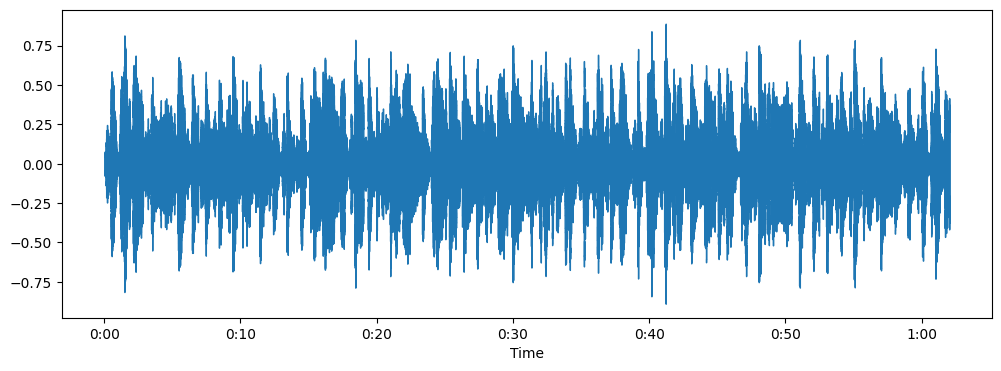

In [9]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data)
plt.show()

<ipython-input-10-37c147d457e9>:5: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')


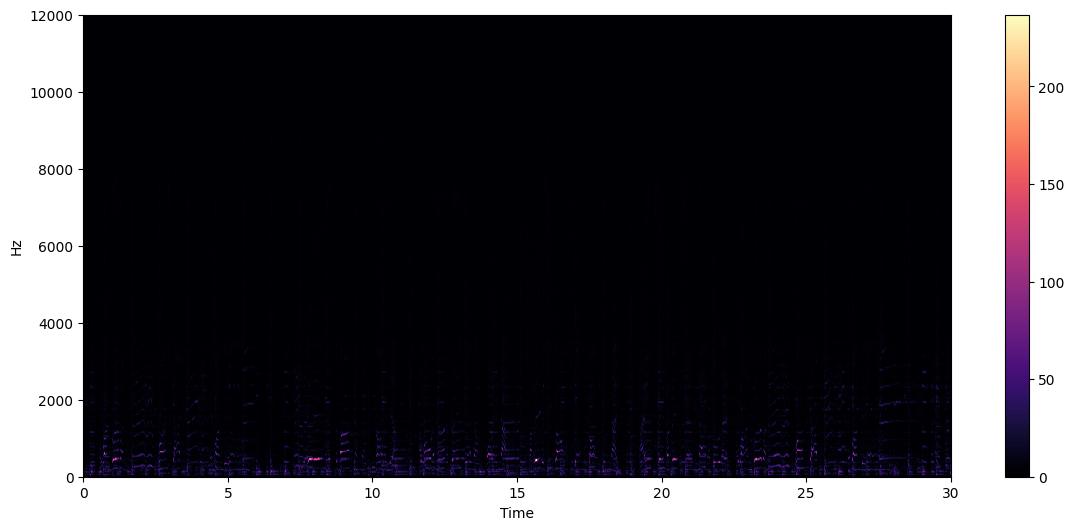

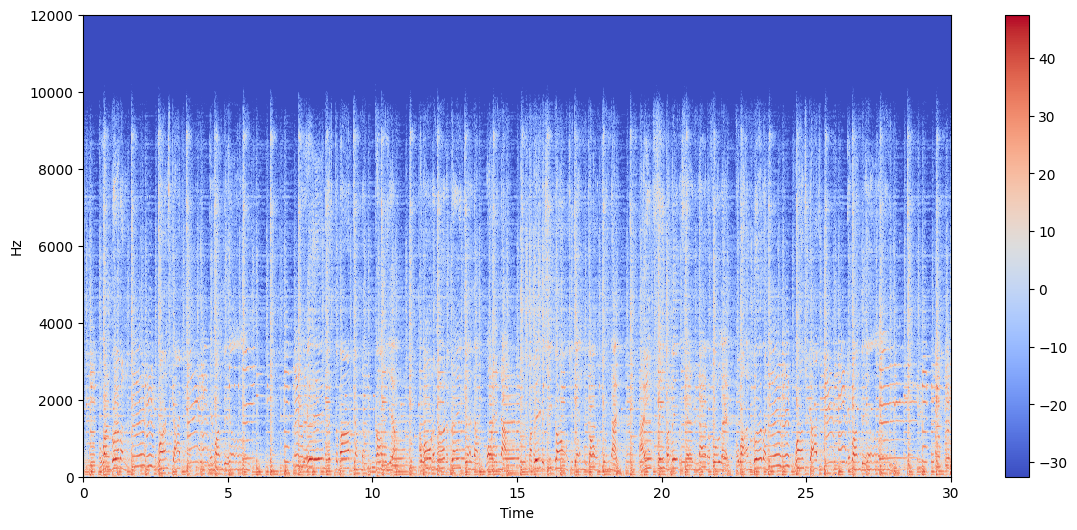

In [10]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))

plt.figure(figsize=(14,6))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 12000)
plt.colorbar()
plt.show()

plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.ylim(0, 12000)
plt.colorbar()
plt.show()

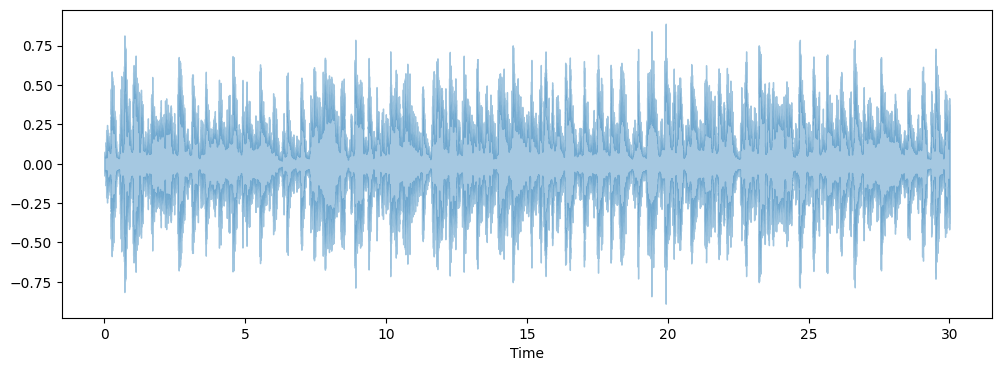

In [11]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=data+0.01, sr=sr)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sr, alpha=0.4)

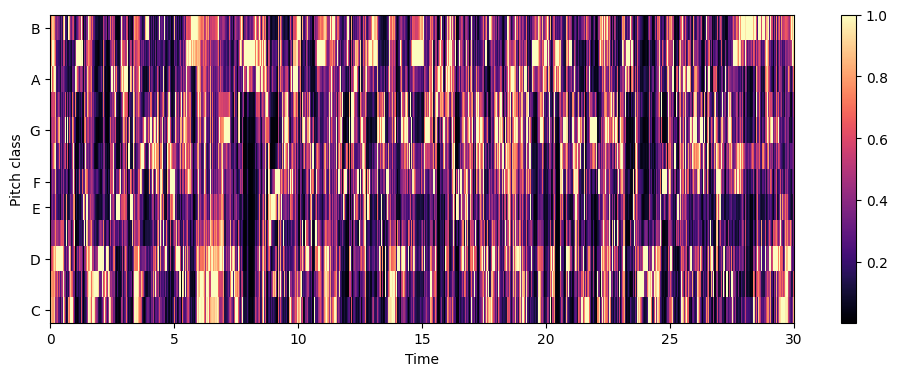

In [12]:
chroma = librosa.feature.chroma_stft(y=data, sr=sr)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()

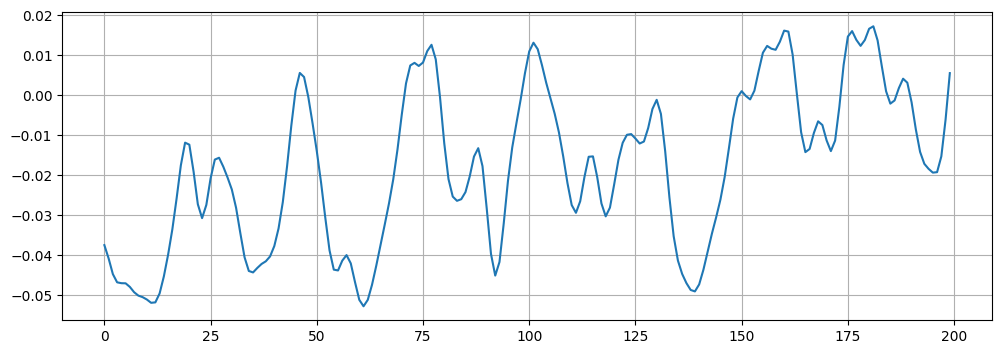

In [13]:
plt.figure(figsize=(12,4))
plt.plot(data[1000:1200])
plt.grid()

In [14]:
zero_cross_rate = librosa.zero_crossings(data[1000:1200])
print("Zero-Crossings:", sum(zero_cross_rate))

Zero-Crossings: 16


## Model Data Allocation

In [15]:
class_list = features3.iloc[:,-1]
converter = LabelEncoder()
y = converter.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [16]:
print(features3.iloc[:,:-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [17]:
fit = StandardScaler()
X = fit.fit_transform(np.array(features3.iloc[:,:-1], dtype=float))
X

array([[ 0.        , -0.48780784,  0.64052047, ..., -0.51356204,
         0.12841417, -0.29178072],
       [ 0.        , -0.40314187,  0.13183473, ...,  1.01138445,
         1.27578001,  0.05642464],
       [ 0.        , -0.36169428,  0.7644909 , ..., -0.04624405,
         0.65390663, -0.52145798],
       ...,
       [ 0.        , -0.35433044,  0.42997426, ..., -0.15370124,
         0.11765485, -0.33882395],
       [ 0.        ,  0.0883611 , -0.00630133, ..., -0.72456977,
         0.30333409, -0.95893743],
       [ 0.        , -0.11321002,  0.19536324, ..., -0.37245283,
        -0.47495901, -0.55112155]])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Model Creation

In [19]:
def trainModel(model, epochs, optimizer):
    batch_size=128
    model.compile(optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy')
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

In [20]:
from IPython.core.display import b2a_base64
def plotValidate(history):
    print("Accuracy", max(history.history["val_accuracy"]))
    ax1 = pd.DataFrame(history.history["val_accuracy"]).plot(figsize=(12,6), c='b')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    ax1.legend(["Accuracy"])
    plt.show()
    print()
    print("Loss", max(history.history["val_loss"]))
    ax2 = pd.DataFrame(history.history["val_loss"]).plot(figsize=(12,6), c='r')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax2.legend(["Loss"])
    plt.show()

In [21]:
model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

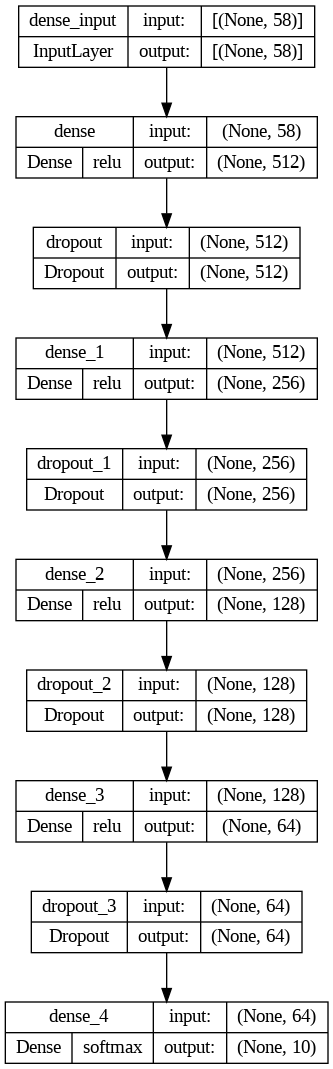

In [23]:
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

## Plotting Model Accuracy and Loss

In [ ]:
model_history = trainModel(model=model, epochs=400, optimizer='sgd')

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=128)
print("Loss:", test_loss)
print("Accuracy", test_acc*100)

26/26 [==============================] - 0s 3ms/step - loss: 0.2988 - accuracy: 0.9060
Loss: 0.298801451921463
Accuracy 90.59751033782959


Accuracy 0.9108280539512634


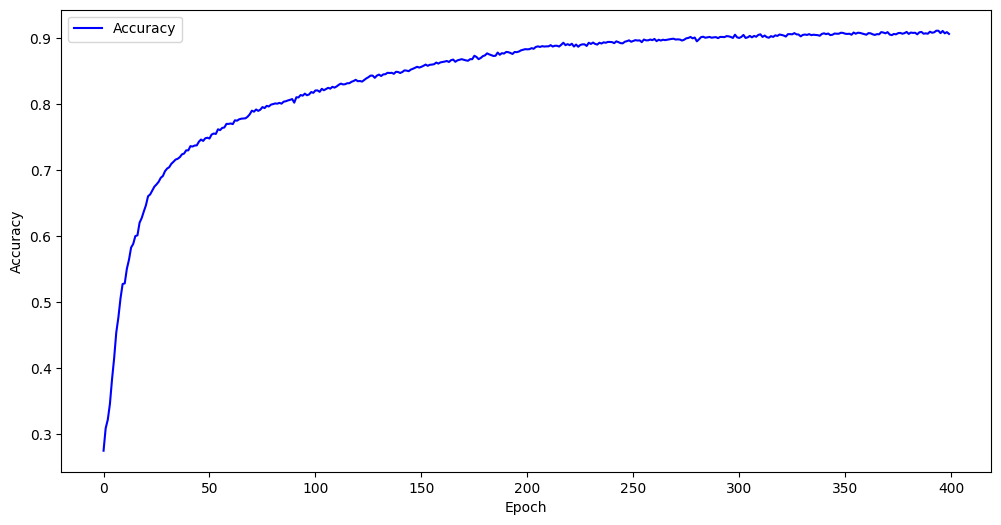


Loss 2.21799635887146


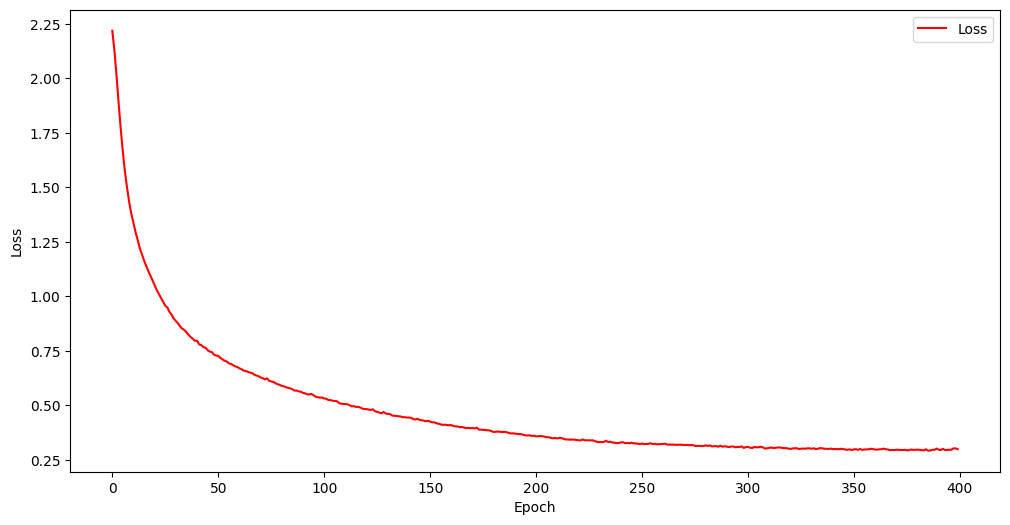

In [26]:
plotValidate(model_history)

## Confusion Matrix

In [27]:
predictions = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, predictions, target_names=classes))

104/104 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

       blues       0.91      0.92      0.92       333
   classical       0.93      0.97      0.95       336
     country       0.84      0.89      0.86       341
       disco       0.88      0.90      0.89       320
      hiphop       0.90      0.89      0.90       322
        jazz       0.93      0.89      0.91       324
       metal       0.97      0.93      0.95       363
         pop       0.93      0.92      0.93       302
      reggae       0.89      0.92      0.91       332
        rock       0.89      0.83      0.86       324

    accuracy                           0.91      3297
   macro avg       0.91      0.91      0.91      3297
weighted avg       0.91      0.91      0.91      3297



<Axes: >

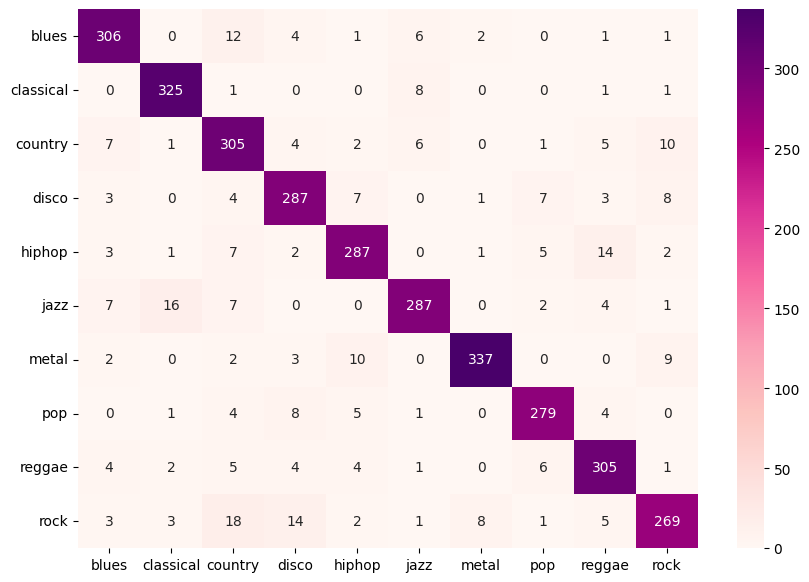

In [28]:
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, cmap="RdPu", fmt='g')